In [588]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,  LabelEncoder, OrdinalEncoder 
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from scipy.stats import pointbiserialr


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from collections import Counter



import joblib

from datetime import datetime

import mysql.connector

from sqlalchemy import create_engine, MetaData, Table, update, select
from sqlalchemy.exc import SQLAlchemyError
from sqlalchemy.sql import text


# 0- Importation du fichier merge preclean

In [522]:
df = pd.read_parquet(r'C:\Users\dimle\Documents\clone_repo\preventive_maintenance\data_preclean_avion_full_compo.parquet')

In [523]:
pd.set_option("display.max_columns", None)

In [524]:
df.head(3)

aero_ measure_day_  usure_nouvelle_max_Ailerons  \
0  A320_1884   2024-06-04                    24.424320   
1  A320_1884   2024-06-05                    25.203096   
2  A320_1884   2024-06-08                    25.466196   

   usure_nouvelle_max_Autopilote  usure_nouvelle_max_Détecteurs_de_fumée  \
0                      30.542460                                6.841880   
1                      31.641138                                7.660764   
2                      32.012313                                7.937414   

   usure_nouvelle_max_Empennage  usure_nouvelle_max_Flaps  \
0                     36.802480                 17.114500   
1                     37.818944                 17.930350   
2                     38.162344                 18.205975   

   usure_nouvelle_max_Freins  usure_nouvelle_max_Gouvernail_de_direction  \
0                  17.502700                                   40.335740   
1                  18.317810                                   41.271322   
2                  18.593185                                   41.587397   

   usure_nouvelle_max_Générateur_électrique  usure_nouvelle_max_Hublots  \
0                                 30.028880                   28.256040   
1                                 31.043864                   33.360412   
2                                 31.386764                   35.084862   

   usure_nouvelle_max_Ordinateur_de_vol  usure_nouvelle_max_Porte_cargo  \
0                             36.529380                       28.500460   
1                             37.302014                       29.347538   
2                             37.563039                       29.633713   

   usure_nouvelle_max_Portes_passagers  \
0                            26.189260   
1                            27.159178   
2                            27.486853   

   usure_nouvelle_max_Radar_météorologique  usure_nouvelle_max_Réacteur_droit  \
0                                35.666140                          43.442680   
1                                36.548442                          44.451004   
2                                36.846517                          44.791654   

   usure_nouvelle_max_Réacteur_gauche  usure_nouvelle_max_Siège_copilote  \
0                           12.128100                            45.7960   
1                           13.093430                            46.8468   
2                           13.419555                            47.2018   

   usure_nouvelle_max_Siège_pilote  usure_nouvelle_max_Spoilers  \
0                        54.049080                    28.316680   
1                        54.944924                    29.310204   
2                        55.247574                    29.645854   

   usure_nouvelle_max_Système_anti-givre  \
0                               8.395260   
1                               9.490978   
2                               9.861153   

   usure_nouvelle_max_Système_d'alerte_de_proximité_au_sol_(GPWS)  \
0                                           9.426140                
1                                          10.197442                
2                                          10.458017                

   usure_nouvelle_max_Système_d'annonce_publique  \
0                                      29.247680   
1                                      30.274504   
2                                      30.621404   

   usure_nouvelle_max_Système_d'approvisionnement_en_eau  \
0                                          38.843280       
1                                          39.790184       
2                                          40.110084       

   usure_nouvelle_max_Système_d'atterrissage_automatique  \
0                                          61.126660       
1                                          62.128398       
2                                          62.466823       

   usure_nouvelle_max_Système_d'extinction_d'incendie  \
0                                          10.6

# 1- clean du dataset pour le ML

In [525]:
df['measure_day_'] = pd.to_datetime(df['measure_day_'])
df['last_maint'] = pd.to_datetime(df['last_maint'])

In [526]:
# ajouter la colonne nb de jour depuis la derniere maintenande
# measure_day_ - last_maint

df['nb_jours_maint'] = df.apply(lambda x: x['measure_day_'] - x['last_maint'], axis=1)

In [527]:
# ajout du nombre de jour depuis la mise en service à jour_vol
df['nb_jours_service'] = df.apply(lambda x: x['measure_day_'] - x['debut_service'], axis=1)

In [528]:
# suppression des colonnes date inutile
df = df.drop(columns=['measure_day', 'last_maint', 'debut_service', 'etat_voyant_suivant'])

In [529]:
# modification du type de variable pour les ecarts de date (passage en integer depuis un timedelta64[ns] en jour)
df['nb_jours_maint'] = df['nb_jours_maint'].dt.days
df['nb_jours_service'] = df['nb_jours_service'].dt.days

In [530]:
df.head(2)

aero_ measure_day_  usure_nouvelle_max_Ailerons  \
0  A320_1884   2024-06-04                    24.424320   
1  A320_1884   2024-06-05                    25.203096   

   usure_nouvelle_max_Autopilote  usure_nouvelle_max_Détecteurs_de_fumée  \
0                      30.542460                                6.841880   
1                      31.641138                                7.660764   

   usure_nouvelle_max_Empennage  usure_nouvelle_max_Flaps  \
0                     36.802480                  17.11450   
1                     37.818944                  17.93035   

   usure_nouvelle_max_Freins  usure_nouvelle_max_Gouvernail_de_direction  \
0                   17.50270                                   40.335740   
1                   18.31781                                   41.271322   

   usure_nouvelle_max_Générateur_électrique  usure_nouvelle_max_Hublots  \
0                                 30.028880                   28.256040   
1                                 31.043864                   33.360412   

   usure_nouvelle_max_Ordinateur_de_vol  usure_nouvelle_max_Porte_cargo  \
0                             36.529380                       28.500460   
1                             37.302014                       29.347538   

   usure_nouvelle_max_Portes_passagers  \
0                            26.189260   
1                            27.159178   

   usure_nouvelle_max_Radar_météorologique  usure_nouvelle_max_Réacteur_droit  \
0                                35.666140                          43.442680   
1                                36.548442                          44.451004   

   usure_nouvelle_max_Réacteur_gauche  usure_nouvelle_max_Siège_copilote  \
0                            12.12810                            45.7960   
1                            13.09343                            46.8468   

   usure_nouvelle_max_Siège_pilote  usure_nouvelle_max_Spoilers  \
0                        54.049080                    28.316680   
1                        54.944924                    29.310204   

   usure_nouvelle_max_Système_anti-givre  \
0                               8.395260   
1                               9.490978   

   usure_nouvelle_max_Système_d'alerte_de_proximité_au_sol_(GPWS)  \
0                                           9.426140                
1                                          10.197442                

   usure_nouvelle_max_Système_d'annonce_publique  \
0                                      29.247680   
1                                      30.274504   

   usure_nouvelle_max_Système_d'approvisionnement_en_eau  \
0                                          38.843280       
1                                          39.790184       

   usure_nouvelle_max_Système_d'atterrissage_automatique  \
0                                          61.126660       
1                                          62.128398       

   usure_nouvelle_max_Système_d'extinction_d'incendie  \
0                                          10.674780    
1                                          11.560634    

   usure_nouvelle_max_Système_de_commande_des_gaz  \
0                                       48.834460   
1                                       49.703738   

   usure_nouvelle_max_Système_de_communication_radio  \
0                                           23.01660   
1                                           23.78398   

   usure_nouvelle_max_Système_de_conditionnement_d'air  \
0                                          60.781740     
1                                          61.547122     

   usure_nouvelle_max_Système_de_contrôle_de_vol  \
0                                       14.73440   
1                                       15.66532   

   usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol  \
0                                           59.58250            
1                                           60.40575            

   usure_nouvelle_max_Système_de_divertissement

In [531]:
df.isna().sum()

aero_                                     0
measure_day_                              0
usure_nouvelle_max_Ailerons               0
usure_nouvelle_max_Autopilote             0
usure_nouvelle_max_Détecteurs_de_fumée    0
                                         ..
type_model                                0
en_maintenance                            0
temps_de_vol_cumule                       0
nb_jours_maint                            0
nb_jours_service                          0
Length: 100, dtype: int64

In [532]:
df.describe().T

count                           mean  \
measure_day_                              5520  2024-06-29 15:38:05.217391360   
usure_nouvelle_max_Ailerons             5520.0                      34.709003   
usure_nouvelle_max_Autopilote           5520.0                      39.580568   
usure_nouvelle_max_Détecteurs_de_fumée  5520.0                      40.195765   
usure_nouvelle_max_Empennage            5520.0                      39.180734   
...                                        ...                            ...   
pressure                                5520.0                     950.724366   
vibrations                              5520.0                       2.519678   
temps_de_vol_cumule                     5520.0                      23.720435   
nb_jours_maint                          5520.0                      79.791667   
nb_jours_service                        5520.0                    4910.673913   

                                                        min  \
measure_day_                            2024-06-02 00:00:00   
usure_nouvelle_max_Ailerons                        0.900392   
usure_nouvelle_max_Autopilote                      1.184492   
usure_nouvelle_max_Détecteurs_de_fumée             0.619696   
usure_nouvelle_max_Empennage                       1.868096   
...                                                     ...   
pressure                                              757.3   
vibrations                                         0.001847   
temps_de_vol_cumule                                     0.6   
nb_jours_maint                                          0.0   
nb_jours_service                                      569.0   

                                                        25%  \
measure_day_                            2024-06-16 00:00:00   
usure_nouvelle_max_Ailerons                       18.775869   
usure_nouvelle_max_Autopilote                     24.810241   
usure_nouvelle_max_Détecteurs_de_fumée             25.80398   
usure_nouvelle_max_Empennage                       24.85393   
...                                                     ...   
pressure                                              917.1   
vibrations                                         1.270467   
temps_de_vol_cumule                                     9.2   
nb_jours_maint                                         25.0   
nb_jours_service                                     2578.0   

                                                        50%  \
measure_day_                            2024-06-30 00:00:00   
usure_nouvelle_max_Ailerons                       33.049056   
usure_nouvelle_max_Autopilote                     38.905826   
usure_nouvelle_max_Détecteurs_de_fumée             40.80224   
usure_nouvelle_max_Empennage                      39.427916   
...                                                     ...   
pressure                                              951.4   
vibrations                                         2.531227   
temps_de_vol_cumule                                    18.6   
nb_jours_maint                                         48.0   
nb_jours_service                                     5038.5   

                                                        75%  \
measure_day_                            2024-07-14 00:00:00   
usure_nouvelle_max_Ailerons                       49.754534   
usure_nouvelle_max_Autopilote                     54.544265   
usure_nouvelle_max_Détecteurs_de_fumée            55.795625   
usure_nouvelle_max_Empennage                      53.416858   
...                                                     ...   
pressure                                              984.8   
vibrations                                          3.77367   
temps_de_vol_cumule                                  33.125   
nb_jours_maint                                        130.0   
nb_jours_service                                     7126.0   

                                        

# 1.bis- Visualisation des data 

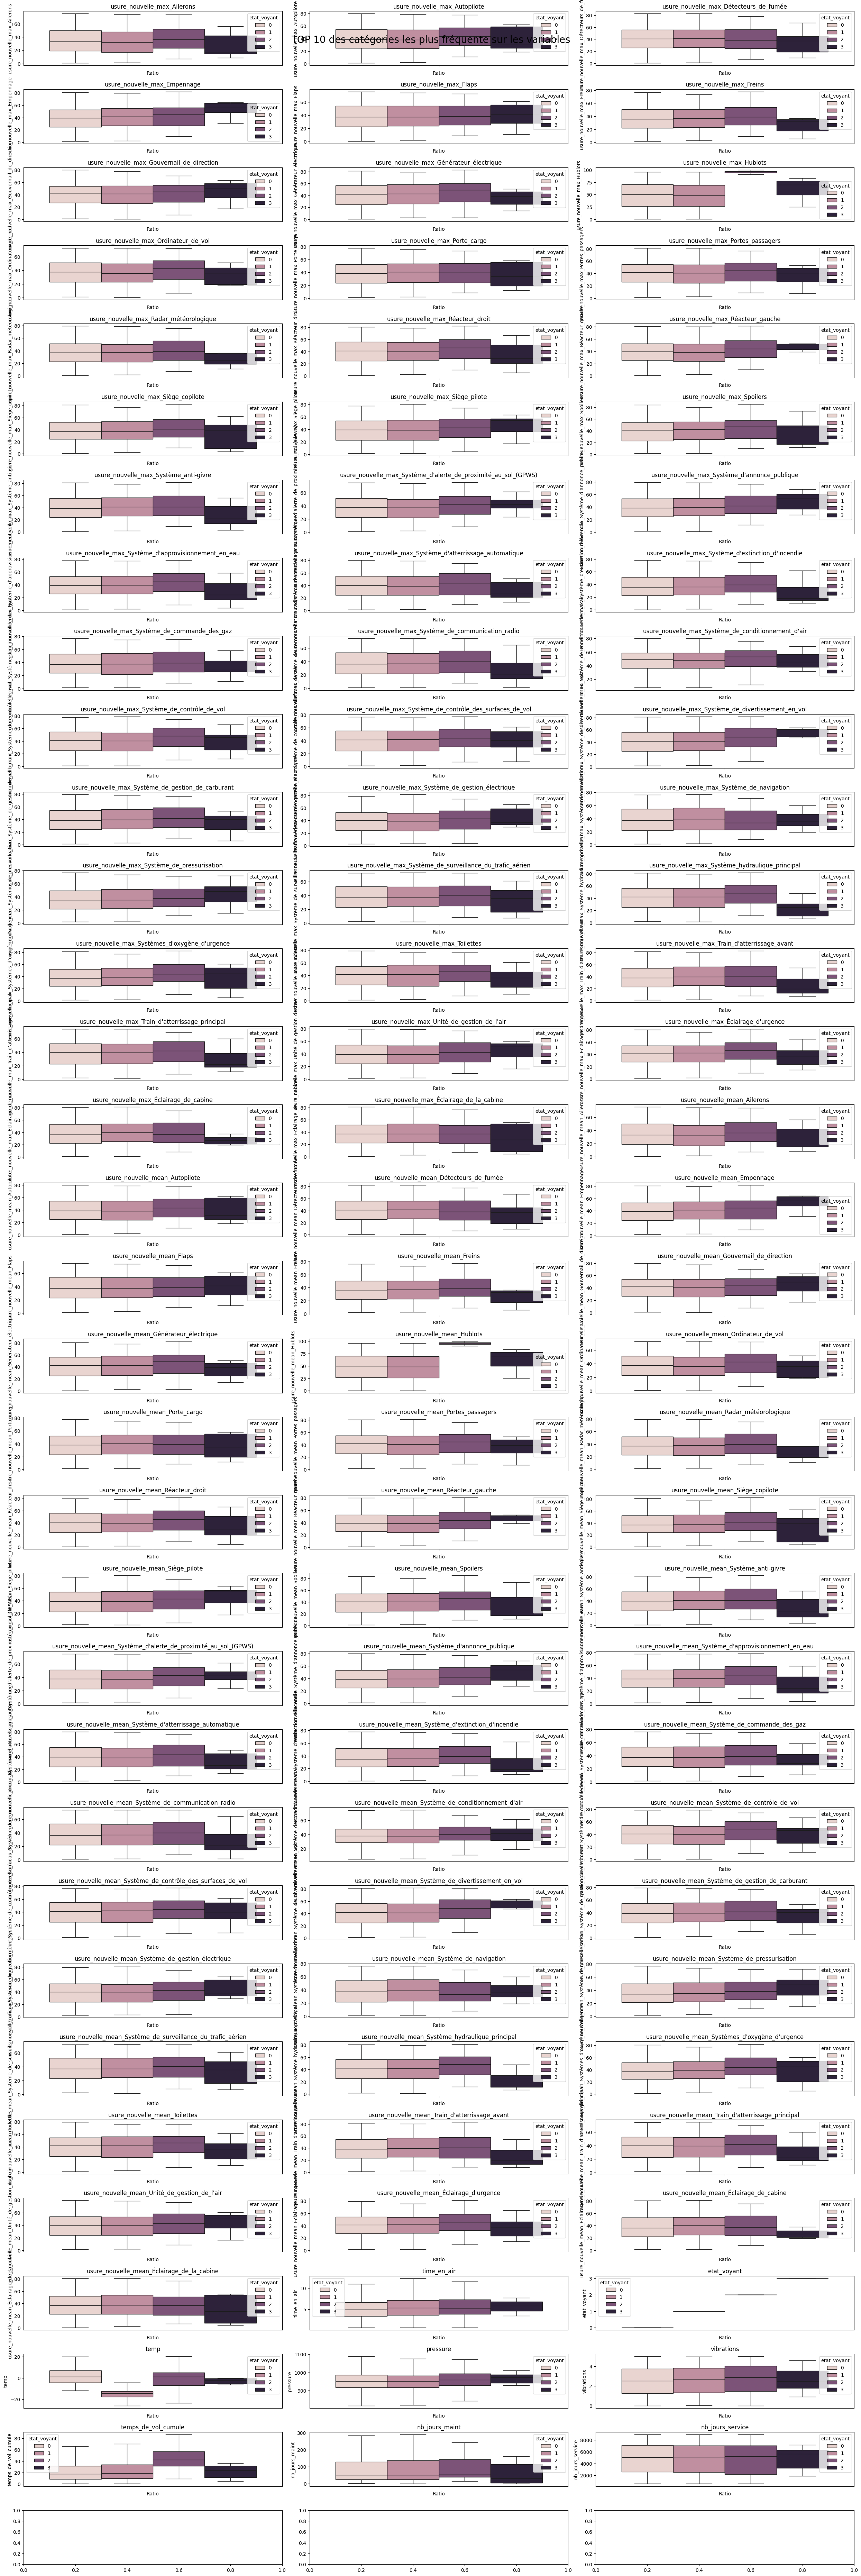

In [533]:
df_num = df.select_dtypes('number')

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(33, 3, figsize=(25, 75))
fig.suptitle('TOP 10 des catégories les plus fréquente sur les variables', fontsize=20)
fig.tight_layout(pad=3.0)

# Parcourir chaque colonne et créer un histogramme
for i, col in enumerate(df_num.columns):
    

    sns.boxplot(data=df, y=col,  ax=axes[i//3, i%3], hue='etat_voyant', showfliers= False)
    axes[i//3, i%3].set_title(col)
    axes[i//3, i%3].set_xlabel('Ratio')
    axes[i//3, i%3].set_ylabel(col)

plt.tight_layout()
plt.show()

In [534]:
# fig_correl, ax_correl = plt.subplots(1,1, figsize = (20,10))

# numerical_corr_matrix = df.select_dtypes(include='number').corr()

# mask = np.triu(np.ones_like(numerical_corr_matrix, dtype=bool))

# annot_kwargs = {
#     "fontsize": 12
# }

# sns.heatmap(numerical_corr_matrix,
#                 center= 0,
#                 cmap = sns.color_palette("vlag", as_cmap=True),
#                 annot= True,
#                 mask= mask,
#                 ax=ax_correl,
#                 linewidths=.5,
#                 fmt= '.2f',
#                 annot_kws= annot_kwargs
#                 )

# ax_correl.set_title('Matrice de corrélation pour Voyant tous les voyants', fontsize= 15)
# ax_correl.set_xticklabels(ax_correl.get_xticklabels(), fontsize=10, rotation = 40)
# ax_correl.set_yticklabels(ax_correl.get_xticklabels(), fontsize=10, rotation = 0)

# plt.show(fig_correl.figure)

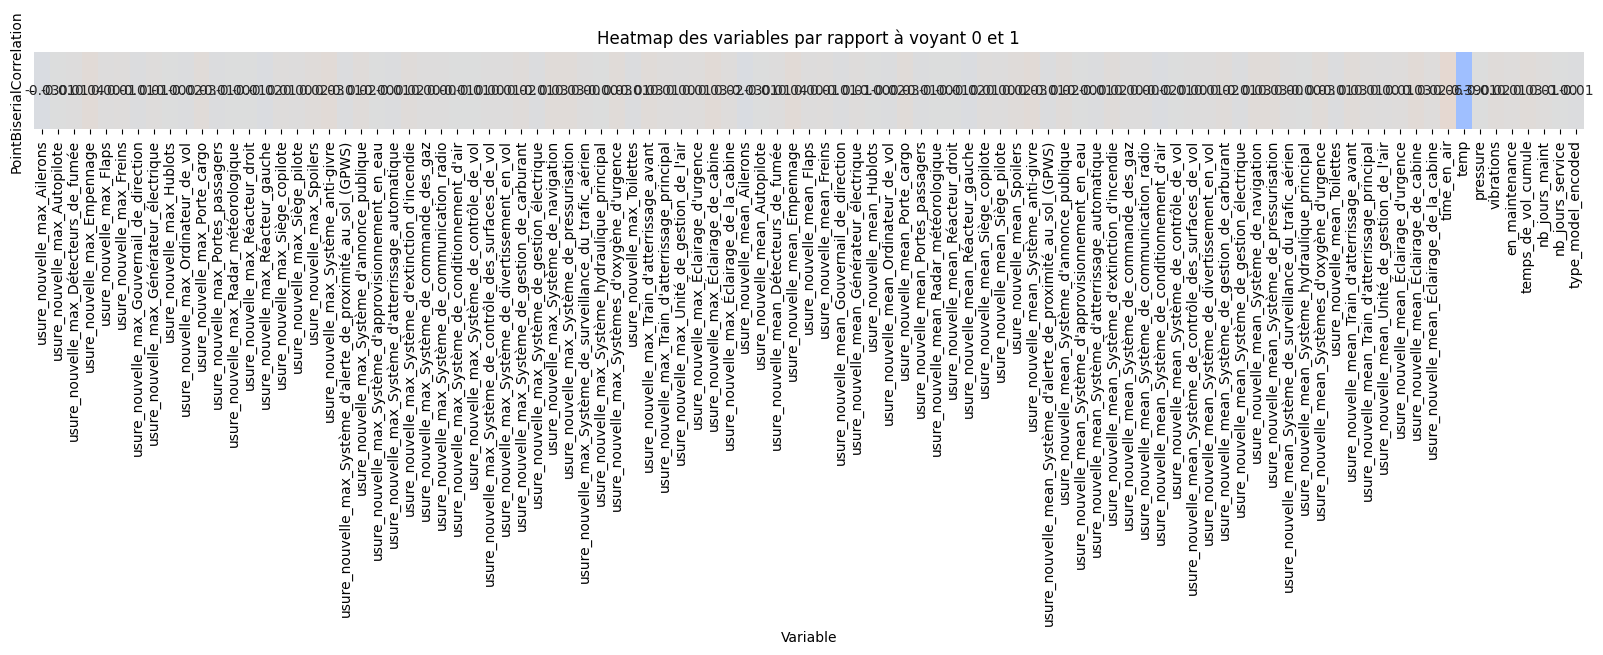

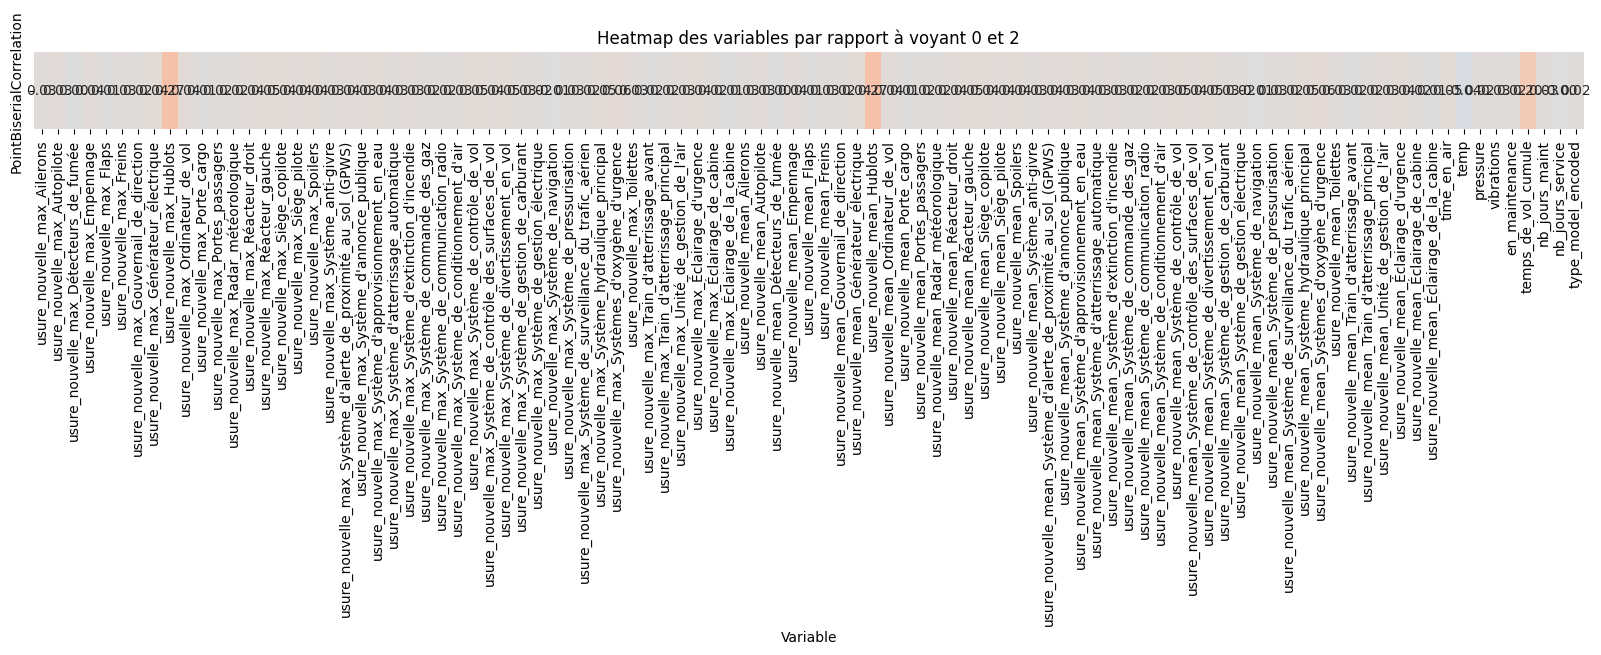

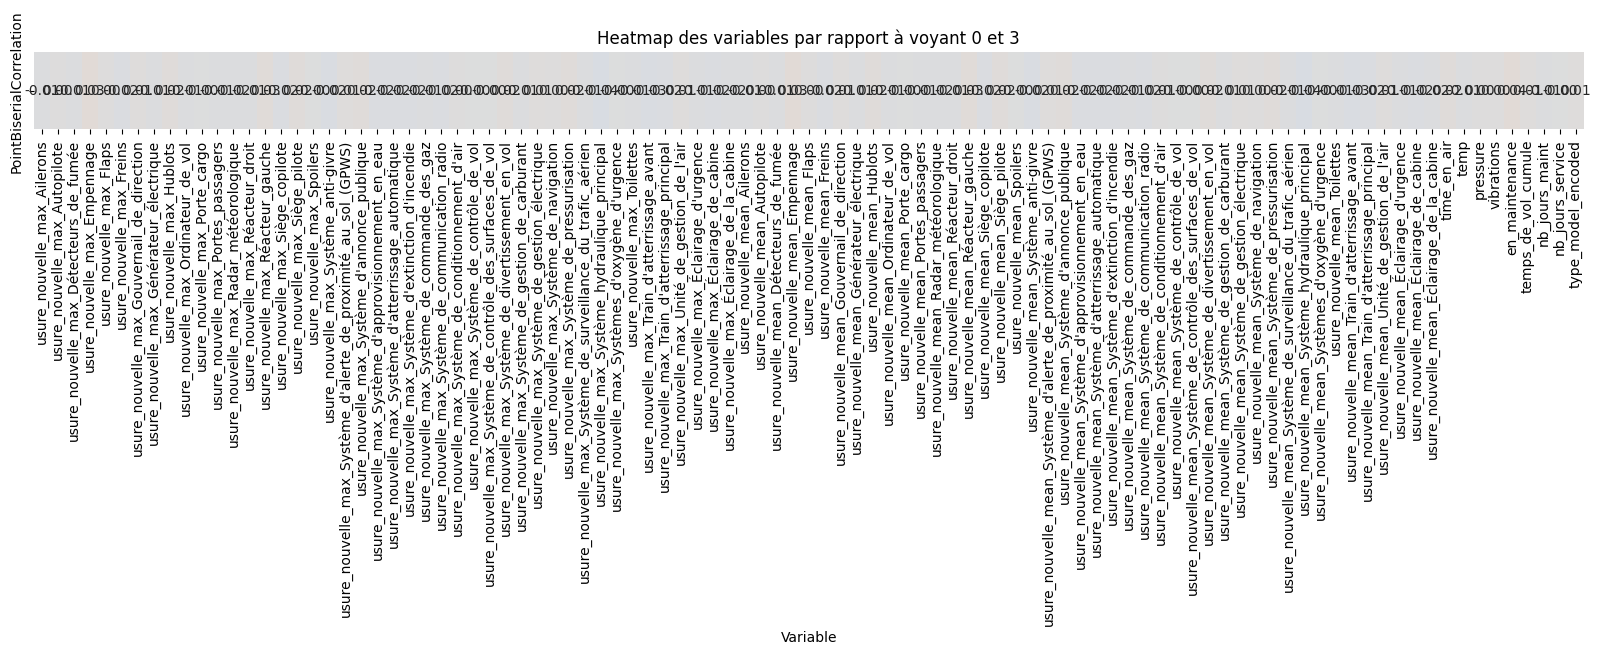

In [535]:
# encodage 0 ou 1 pour la class etat_voyant trié à 3

label_encoder = LabelEncoder()

for i in range(0,4,1):
    if i!=0:

        df_3 = df[(df['etat_voyant']==i) | (df['etat_voyant']==0)].copy()

        df_3['etat_voyant_encoded'] = label_encoder.fit_transform(df_3['etat_voyant'])
        df_3['type_model_encoded'] = label_encoder.fit_transform(df_3['type_model'])

        df_3.drop(['etat_voyant', 'type_model', 'measure_day_'], axis=1, inplace=True)

        continuous_cols = df_3.drop(columns=['etat_voyant_encoded', 'aero_' ])

        # Calculer la corrélation bisériale ponctuelle pour chaque variable continue
        correlations = {}

        for col in continuous_cols.columns:

            correlations[col] = pointbiserialr(df_3['etat_voyant_encoded'], df_3[col])[0]


        # Convertir le dictionnaire en DataFrame pour la heatmap
        corr_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'PointBiserialCorrelation'])
        corr_df.set_index('Variable', inplace=True)


        plt.figure(figsize=(20, 1))
        sns.heatmap(corr_df.T, annot=True, cmap='coolwarm', cbar=False, fmt=".2f", vmin=-1, vmax= 1)
        plt.title(f'Heatmap des variables par rapport à voyant {0} et {i}')


        plt.show()

# 2- Prepa des données et pipeline pour ML

In [536]:
df.select_dtypes(exclude='number').columns


Index(['aero_', 'measure_day_', 'type_model', 'en_maintenance'], dtype='object')

In [537]:
features_std = [
'usure_nouvelle_max_Ailerons', 
'usure_nouvelle_max_Autopilote',
       'usure_nouvelle_max_Détecteurs_de_fumée',
       'usure_nouvelle_max_Empennage', 
       'usure_nouvelle_max_Flaps',
       'usure_nouvelle_max_Freins',
       'usure_nouvelle_max_Gouvernail_de_direction',
       'usure_nouvelle_max_Générateur_électrique',
       'usure_nouvelle_max_Hublots', 
       'usure_nouvelle_max_Ordinateur_de_vol',
       'usure_nouvelle_max_Porte_cargo', 
       'usure_nouvelle_max_Portes_passagers',
       'usure_nouvelle_max_Radar_météorologique',
       'usure_nouvelle_max_Réacteur_droit',
       'usure_nouvelle_max_Réacteur_gauche',
       'usure_nouvelle_max_Siège_copilote', 
       'usure_nouvelle_max_Siège_pilote',
       'usure_nouvelle_max_Spoilers', 
       'usure_nouvelle_max_Système_anti-givre',
       'usure_nouvelle_max_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_max_Système_d\'annonce_publique',
       'usure_nouvelle_max_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_max_Système_d\'atterrissage_automatique',
       'usure_nouvelle_max_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_max_Système_de_commande_des_gaz',
       'usure_nouvelle_max_Système_de_communication_radio',
       'usure_nouvelle_max_Système_de_conditionnement_d\'air',
       'usure_nouvelle_max_Système_de_contrôle_de_vol',
       'usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_max_Système_de_divertissement_en_vol',
       'usure_nouvelle_max_Système_de_gestion_de_carburant',
       'usure_nouvelle_max_Système_de_gestion_électrique',
       'usure_nouvelle_max_Système_de_navigation',
       'usure_nouvelle_max_Système_de_pressurisation',
       'usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_max_Système_hydraulique_principal',
       'usure_nouvelle_max_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_max_Toilettes',
       'usure_nouvelle_max_Train_d\'atterrissage_avant',
       'usure_nouvelle_max_Train_d\'atterrissage_principal',
       'usure_nouvelle_max_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_max_Éclairage_d\'urgence',
       'usure_nouvelle_max_Éclairage_de_cabine',
       'usure_nouvelle_max_Éclairage_de_la_cabine',
       'usure_nouvelle_mean_Ailerons', 
       'usure_nouvelle_mean_Autopilote',
       'usure_nouvelle_mean_Détecteurs_de_fumée',
       'usure_nouvelle_mean_Empennage', 
       'usure_nouvelle_mean_Flaps',
       'usure_nouvelle_mean_Freins',
       'usure_nouvelle_mean_Gouvernail_de_direction',
       'usure_nouvelle_mean_Générateur_électrique',
       'usure_nouvelle_mean_Hublots', 
       'usure_nouvelle_mean_Ordinateur_de_vol',
       'usure_nouvelle_mean_Porte_cargo',
       'usure_nouvelle_mean_Portes_passagers',
       'usure_nouvelle_mean_Radar_météorologique',
       'usure_nouvelle_mean_Réacteur_droit',
       'usure_nouvelle_mean_Réacteur_gauche',
       'usure_nouvelle_mean_Siège_copilote',
       'usure_nouvelle_mean_Siège_pilote', 
       'usure_nouvelle_mean_Spoilers',
       'usure_nouvelle_mean_Système_anti-givre',
       'usure_nouvelle_mean_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_mean_Système_d\'annonce_publique',
       'usure_nouvelle_mean_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_mean_Système_d\'atterrissage_automatique',
       'usure_nouvelle_mean_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_mean_Système_de_commande_des_gaz',
       'usure_nouvelle_mean_Système_de_communication_radio',
       'usure_nouvelle_mean_Système_de_conditionnement_d\'air',
       'usure_nouvelle_mean_Système_de_contrôle_de_vol',
       'usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_mean_Système_de_divertissement_en_vol',
       'usure_nouvelle_mean_Système_de_gestion_de_carburant',
       'usure_nouvelle_mean_Système_de_gestion_électrique',
       'usure_nouvelle_mean_Système_de_navigation',
       'usure_nouvelle_mean_Système_de_pressurisation',
       'usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_mean_Système_hydraulique_principal',
       'usure_nouvelle_mean_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_mean_Toilettes',
       'usure_nouvelle_mean_Train_d\'atterrissage_avant',
       'usure_nouvelle_mean_Train_d\'atterrissage_principal',
       'usure_nouvelle_mean_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_mean_Éclairage_d\'urgence',
       'usure_nouvelle_mean_Éclairage_de_cabine',
       'usure_nouvelle_mean_Éclairage_de_la_cabine', 
       'time_en_air',
       'temp', 
       'pressure', 
       'vibrations', 
       'temps_de_vol_cumule',
       'nb_jours_maint', 
       'nb_jours_service'
]

features_oneHot = ['type_model']


features_binar =['en_maintenance']

In [538]:
# Préparation des transformateurs pour les caractéristiques numériques
numeric_transformer_std = (ImbPipeline( steps= [
    ('stdScaller', StandardScaler())
]))

categ_transformer_onehot = (ImbPipeline( steps= [
    ('OneHot', OneHotEncoder())
]))

categ_transformer_bin = (ImbPipeline( steps= [
    ('bina', OrdinalEncoder())
]))


# Combinaison des transformation pour le preprocessing
preprocessor = ColumnTransformer(
    transformers= [
        ('num_std', numeric_transformer_std, features_std),
        ('cat_oneHot', categ_transformer_onehot, features_oneHot),
        ('cat_bin', categ_transformer_bin, features_binar)
    ]
)

In [539]:
y = df['etat_voyant'] 

X = df[['usure_nouvelle_max_Ailerons', 
'usure_nouvelle_max_Autopilote',
       'usure_nouvelle_max_Détecteurs_de_fumée',
       'usure_nouvelle_max_Empennage', 
       'usure_nouvelle_max_Flaps',
       'usure_nouvelle_max_Freins',
       'usure_nouvelle_max_Gouvernail_de_direction',
       'usure_nouvelle_max_Générateur_électrique',
       'usure_nouvelle_max_Hublots', 
       'usure_nouvelle_max_Ordinateur_de_vol',
       'usure_nouvelle_max_Porte_cargo', 
       'usure_nouvelle_max_Portes_passagers',
       'usure_nouvelle_max_Radar_météorologique',
       'usure_nouvelle_max_Réacteur_droit',
       'usure_nouvelle_max_Réacteur_gauche',
       'usure_nouvelle_max_Siège_copilote', 
       'usure_nouvelle_max_Siège_pilote',
       'usure_nouvelle_max_Spoilers', 
       'usure_nouvelle_max_Système_anti-givre',
       'usure_nouvelle_max_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_max_Système_d\'annonce_publique',
       'usure_nouvelle_max_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_max_Système_d\'atterrissage_automatique',
       'usure_nouvelle_max_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_max_Système_de_commande_des_gaz',
       'usure_nouvelle_max_Système_de_communication_radio',
       'usure_nouvelle_max_Système_de_conditionnement_d\'air',
       'usure_nouvelle_max_Système_de_contrôle_de_vol',
       'usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_max_Système_de_divertissement_en_vol',
       'usure_nouvelle_max_Système_de_gestion_de_carburant',
       'usure_nouvelle_max_Système_de_gestion_électrique',
       'usure_nouvelle_max_Système_de_navigation',
       'usure_nouvelle_max_Système_de_pressurisation',
       'usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_max_Système_hydraulique_principal',
       'usure_nouvelle_max_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_max_Toilettes',
       'usure_nouvelle_max_Train_d\'atterrissage_avant',
       'usure_nouvelle_max_Train_d\'atterrissage_principal',
       'usure_nouvelle_max_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_max_Éclairage_d\'urgence',
       'usure_nouvelle_max_Éclairage_de_cabine',
       'usure_nouvelle_max_Éclairage_de_la_cabine',
       'usure_nouvelle_mean_Ailerons', 
       'usure_nouvelle_mean_Autopilote',
       'usure_nouvelle_mean_Détecteurs_de_fumée',
       'usure_nouvelle_mean_Empennage', 
       'usure_nouvelle_mean_Flaps',
       'usure_nouvelle_mean_Freins',
       'usure_nouvelle_mean_Gouvernail_de_direction',
       'usure_nouvelle_mean_Générateur_électrique',
       'usure_nouvelle_mean_Hublots', 
       'usure_nouvelle_mean_Ordinateur_de_vol',
       'usure_nouvelle_mean_Porte_cargo',
       'usure_nouvelle_mean_Portes_passagers',
       'usure_nouvelle_mean_Radar_météorologique',
       'usure_nouvelle_mean_Réacteur_droit',
       'usure_nouvelle_mean_Réacteur_gauche',
       'usure_nouvelle_mean_Siège_copilote',
       'usure_nouvelle_mean_Siège_pilote', 
       'usure_nouvelle_mean_Spoilers',
       'usure_nouvelle_mean_Système_anti-givre',
       'usure_nouvelle_mean_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_mean_Système_d\'annonce_publique',
       'usure_nouvelle_mean_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_mean_Système_d\'atterrissage_automatique',
       'usure_nouvelle_mean_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_mean_Système_de_commande_des_gaz',
       'usure_nouvelle_mean_Système_de_communication_radio',
       'usure_nouvelle_mean_Système_de_conditionnement_d\'air',
       'usure_nouvelle_mean_Système_de_contrôle_de_vol',
       'usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_mean_Système_de_divertissement_en_vol',
       'usure_nouvelle_mean_Système_de_gestion_de_carburant',
       'usure_nouvelle_mean_Système_de_gestion_électrique',
       'usure_nouvelle_mean_Système_de_navigation',
       'usure_nouvelle_mean_Système_de_pressurisation',
       'usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_mean_Système_hydraulique_principal',
       'usure_nouvelle_mean_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_mean_Toilettes',
       'usure_nouvelle_mean_Train_d\'atterrissage_avant',
       'usure_nouvelle_mean_Train_d\'atterrissage_principal',
       'usure_nouvelle_mean_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_mean_Éclairage_d\'urgence',
       'usure_nouvelle_mean_Éclairage_de_cabine',
       'usure_nouvelle_mean_Éclairage_de_la_cabine', 
       'time_en_air',
       'temp', 
       'pressure', 
       'vibrations', 
       'temps_de_vol_cumule',
       'nb_jours_maint', 
       'nb_jours_service',
       'type_model',
       'en_maintenance'
       ]]

In [540]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

# 3- Essai de modele

## 3.1- XGBClassifier

In [541]:
RL_model = XGBClassifier()

In [542]:
pipeline_reg_log = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=3, random_state=42)),
    ('model', RL_model)
])

In [543]:
param_dist_xgbc = {
    'model__n_estimators': [50, 100, 200, 300, 400, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'model__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bynode': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'model__min_child_weight': [1, 2, 3, 4, 5, 6],
    'model__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'model__reg_lambda': [1, 0.1, 0.01, 0.001, 0],
    'model__eval_metric': ['mlogloss', 'logloss'],
}


In [544]:
random_search_xgbc = RandomizedSearchCV(
    estimator=pipeline_reg_log,
    param_distributions=param_dist_xgbc,
    n_iter=50,  
    scoring='accuracy',
    verbose=1,
    random_state=42,
    cv=5,
    n_jobs=-1  
)

{'recall_micro', 'neg_mean_absolute_error', 'jaccard_micro', 'neg_root_mean_squared_error', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'balanced_accuracy', 'neg_mean_squared_log_error', 'f1_weighted', 'roc_auc', 'neg_mean_squared_error', 'explained_variance', 'r2', 'recall', 'recall_weighted', 'completeness_score', 'precision_macro', 'neg_brier_score', 'precision', 'neg_mean_gamma_deviance', 'f1_samples', 'f1_macro', 'homogeneity_score', 'recall_samples', 'd2_absolute_error_score', 'v_measure_score', 'precision_samples', 'accuracy', 'roc_auc_ovo_weighted', 'max_error', 'adjusted_mutual_info_score', 'neg_root_mean_squared_log_error', 'jaccard_weighted', 'jaccard_samples', 'positive_likelihood_ratio', 'neg_mean_poisson_deviance', 'neg_negative_likelihood_ratio', 'roc_auc_ovr', 'average_precision', 'precision_weighted', 'neg_mean_absolute_percentage_error', 'neg_median_absolute_error', 'precision_micro', 'neg_log_loss', 'f1', 'matthews_corrcoef', 'rand_score', 'fowlkes_mallows_score', 'jaccard', 'normalized_mutual_info_score', 'top_k_accuracy', 'adjusted_rand_score', 'jaccard_macro', 'f1_micro', 'mutual_info_score', 'recall_macro'}

In [545]:
random_search_xgbc.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_std',
                                                                               Pipeline(steps=[('stdScaller',
                                                                                                StandardScaler())]),
                                                                               ['usure_nouvelle_max_Ailerons',
                                                                                'usure_nouvelle_max_Autopilote',
                                                                                'usure_nouvelle_max_Détecteurs_de_fumée',
                                                                                'usure_nouvelle_max_Empennage',
                                                                                'usure_nouvelle_max_Flaps',
                                                                                'usure_nouvelle_max_Freins',
                                                                                '...
                                                         0.5],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2, 0.3,
                                                                 0.4],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__min_child_weight': [1, 2, 3, 4,
                                                                    5, 6],
                                        'model__n_estimators': [50, 100, 200,
                                                                300, 400, 500],
                                        'model__reg_alpha': [0, 0.01, 0.1, 1,
                                                             10],
                                        'model__reg_lambda': [1, 0.1, 0.01,
                                                              0.001, 0],
                                        'model__subsample': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [546]:
# Afficher les meilleurs paramètres trouvés
print("Best parameters found: ", random_search_xgbc.best_params_)

# Évaluer le modèle sur l'ensemble de test
best_model_xgbc = random_search_xgbc.best_estimator_

Best parameters found:  {'model__subsample': 1.0, 'model__reg_lambda': 0.01, 'model__reg_alpha': 0.1, 'model__n_estimators': 300, 'model__min_child_weight': 6, 'model__max_depth': 6, 'model__learning_rate': 0.01, 'model__gamma': 0.4, 'model__eval_metric': 'logloss', 'model__colsample_bytree': 1.0, 'model__colsample_bynode': 0.5, 'model__colsample_bylevel': 0.8}


In [547]:
y_pred_rl = best_model_xgbc.predict(X_test)

In [548]:
accuracy_rl = accuracy_score(y_test, y_pred_rl)

print(f'Accuracy: {accuracy_rl:.4f}')

Accuracy: 0.9703


In [549]:
class_report_rl = classification_report(y_test, y_pred_rl)

print(class_report_rl)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1159
           1       0.98      0.93      0.95       187
           2       0.68      0.84      0.75        32
           3       0.00      0.00      0.00         2

    accuracy                           0.97      1380
   macro avg       0.66      0.69      0.67      1380
weighted avg       0.97      0.97      0.97      1380



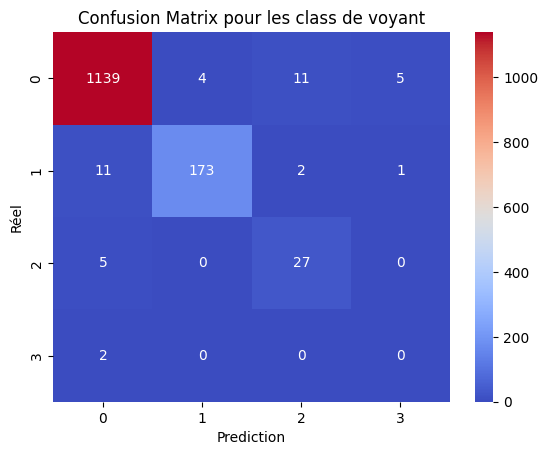

In [550]:
conf_matrix_rl = confusion_matrix(y_test, y_pred_rl)

sns.heatmap(conf_matrix_rl, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Réel')

plt.title('Confusion Matrix pour les class de voyant')
plt.show()

# 3- Enregistrement du modele

In [551]:

# Enregistrer le modèle dans un fichier
joblib.dump(best_model_xgbc, 'best_model_avion_full_compo.pkl')

['best_model_avion_full_compo.pkl']

# 4- Essai de modele avec serie temporelle

In [552]:
liste_pour_lag = [      
       'usure_nouvelle_max_Ailerons', 
       'usure_nouvelle_max_Autopilote',
       'usure_nouvelle_max_Détecteurs_de_fumée',
       'usure_nouvelle_max_Empennage', 
       'usure_nouvelle_max_Flaps',
       'usure_nouvelle_max_Freins',
       'usure_nouvelle_max_Gouvernail_de_direction',
       'usure_nouvelle_max_Générateur_électrique',
       'usure_nouvelle_max_Hublots', 
       'usure_nouvelle_max_Ordinateur_de_vol',
       'usure_nouvelle_max_Porte_cargo', 
       'usure_nouvelle_max_Portes_passagers',
       'usure_nouvelle_max_Radar_météorologique',
       'usure_nouvelle_max_Réacteur_droit',
       'usure_nouvelle_max_Réacteur_gauche',
       'usure_nouvelle_max_Siège_copilote', 
       'usure_nouvelle_max_Siège_pilote',
       'usure_nouvelle_max_Spoilers', 
       'usure_nouvelle_max_Système_anti-givre',
       'usure_nouvelle_max_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_max_Système_d\'annonce_publique',
       'usure_nouvelle_max_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_max_Système_d\'atterrissage_automatique',
       'usure_nouvelle_max_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_max_Système_de_commande_des_gaz',
       'usure_nouvelle_max_Système_de_communication_radio',
       'usure_nouvelle_max_Système_de_conditionnement_d\'air',
       'usure_nouvelle_max_Système_de_contrôle_de_vol',
       'usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_max_Système_de_divertissement_en_vol',
       'usure_nouvelle_max_Système_de_gestion_de_carburant',
       'usure_nouvelle_max_Système_de_gestion_électrique',
       'usure_nouvelle_max_Système_de_navigation',
       'usure_nouvelle_max_Système_de_pressurisation',
       'usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_max_Système_hydraulique_principal',
       'usure_nouvelle_max_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_max_Toilettes',
       'usure_nouvelle_max_Train_d\'atterrissage_avant',
       'usure_nouvelle_max_Train_d\'atterrissage_principal',
       'usure_nouvelle_max_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_max_Éclairage_d\'urgence',
       'usure_nouvelle_max_Éclairage_de_cabine',
       'usure_nouvelle_max_Éclairage_de_la_cabine',
       'usure_nouvelle_mean_Ailerons', 
       'usure_nouvelle_mean_Autopilote',
       'usure_nouvelle_mean_Détecteurs_de_fumée',
       'usure_nouvelle_mean_Empennage', 
       'usure_nouvelle_mean_Flaps',
       'usure_nouvelle_mean_Freins',
       'usure_nouvelle_mean_Gouvernail_de_direction',
       'usure_nouvelle_mean_Générateur_électrique',
       'usure_nouvelle_mean_Hublots', 
       'usure_nouvelle_mean_Ordinateur_de_vol',
       'usure_nouvelle_mean_Porte_cargo',
       'usure_nouvelle_mean_Portes_passagers',
       'usure_nouvelle_mean_Radar_météorologique',
       'usure_nouvelle_mean_Réacteur_droit',
       'usure_nouvelle_mean_Réacteur_gauche',
       'usure_nouvelle_mean_Siège_copilote',
       'usure_nouvelle_mean_Siège_pilote', 
       'usure_nouvelle_mean_Spoilers',
       'usure_nouvelle_mean_Système_anti-givre',
       'usure_nouvelle_mean_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_mean_Système_d\'annonce_publique',
       'usure_nouvelle_mean_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_mean_Système_d\'atterrissage_automatique',
       'usure_nouvelle_mean_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_mean_Système_de_commande_des_gaz',
       'usure_nouvelle_mean_Système_de_communication_radio',
       'usure_nouvelle_mean_Système_de_conditionnement_d\'air',
       'usure_nouvelle_mean_Système_de_contrôle_de_vol',
       'usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_mean_Système_de_divertissement_en_vol',
       'usure_nouvelle_mean_Système_de_gestion_de_carburant',
       'usure_nouvelle_mean_Système_de_gestion_électrique',
       'usure_nouvelle_mean_Système_de_navigation',
       'usure_nouvelle_mean_Système_de_pressurisation',
       'usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_mean_Système_hydraulique_principal',
       'usure_nouvelle_mean_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_mean_Toilettes',
       'usure_nouvelle_mean_Train_d\'atterrissage_avant',
       'usure_nouvelle_mean_Train_d\'atterrissage_principal',
       'usure_nouvelle_mean_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_mean_Éclairage_d\'urgence',
       'usure_nouvelle_mean_Éclairage_de_cabine',
       'usure_nouvelle_mean_Éclairage_de_la_cabine', 
       'time_en_air',
       'temp', 
       'pressure', 
       'vibrations', 
       'temps_de_vol_cumule',
       'nb_jours_maint', 
       'nb_jours_service',
       'type_model',
       'en_maintenance'
       ]


In [553]:
# Création des valeurs décalées (lagged values)

# Nombre de jour pour voir l'évolution temporel
nb_vol_etude = 6

for var in liste_pour_lag:

    for lag in range(1, nb_vol_etude+1):

        df[f'{var}_lag_{lag}'] = df[var].shift(lag)


C:\Users\dimle\AppData\Local\Temp\ipykernel_31120\1589254840.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag_{lag}'] = df[var].shift(lag)
C:\Users\dimle\AppData\Local\Temp\ipykernel_31120\1589254840.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag_{lag}'] = df[var].shift(lag)
C:\Users\dimle\AppData\Local\Temp\ipykernel_31120\1589254840.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

In [554]:
list_drop = []
for i in df.columns:

    if i in X.columns:
        pass
    else:
        list_drop.append(i)

In [555]:
# Suppression des lignes avec des valeurs manquantes dues aux décalages des jours
df = df.dropna()

X=df

# Séparation des caractéristiques et de la cible
y = df['etat_voyant'] 


In [556]:
# Division en ensembles d'entraînement et de test
split_date = datetime(2024, 7, 19)

# ajuster en fonction de votre dataset
X_train = X[df['measure_day_'] < split_date]
X_test = X[df['measure_day_'] >= split_date]
y_train = y[df['measure_day_'] < split_date]
y_test = y[df['measure_day_'] >= split_date]


In [557]:
# suppresion des données du vol
X = df.drop(list_drop, axis=1)

X_train = X_train.drop(list_drop, axis=1)
X_test = X_test.drop(list_drop, axis=1)

In [558]:
# Entraînement du modèle
RL_model = XGBClassifier()


In [559]:
# Préparation des transformateurs pour les caractéristiques numériques
numeric_transformer_std = (ImbPipeline( steps= [
    ('stdScaller', StandardScaler())
]))

categ_transformer_onehot = (ImbPipeline( steps= [
    ('OneHot', OneHotEncoder())
]))

categ_transformer_bin = (ImbPipeline( steps= [
    ('bina', OrdinalEncoder())
]))


# Combinaison des transformation pour le preprocessing
preprocessor = ColumnTransformer(
    transformers= [
        ('num_std', numeric_transformer_std, features_std),
        ('cat_oneHot', categ_transformer_onehot, features_oneHot),
        ('cat_bin', categ_transformer_bin, features_binar)
    ]
)

pipeline_reg_log = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=1, random_state=42)),
    ('model', RL_model)
])


In [560]:
pipeline_reg_log.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_std',
                                                  Pipeline(steps=[('stdScaller',
                                                                   StandardScaler())]),
                                                  ['usure_nouvelle_max_Ailerons',
                                                   'usure_nouvelle_max_Autopilote',
                                                   'usure_nouvelle_max_Détecteurs_de_fumée',
                                                   'usure_nouvelle_max_Empennage',
                                                   'usure_nouvelle_max_Flaps',
                                                   'usure_nouvelle_max_Freins',
                                                   'usure_nouvelle_max_Gouvernail_de_d...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [561]:
# Prédiction et évaluation
y_pred = pipeline_reg_log.predict(X_test)

In [562]:
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.98


In [563]:
class_report_rl = classification_report(y_test, y_pred)

print(class_report_rl)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       691
           1       0.97      0.97      0.97       128
           2       0.89      0.77      0.83        31
           3       0.00      0.00      0.00         0

    accuracy                           0.98       850
   macro avg       0.71      0.68      0.70       850
weighted avg       0.98      0.98      0.98       850



c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

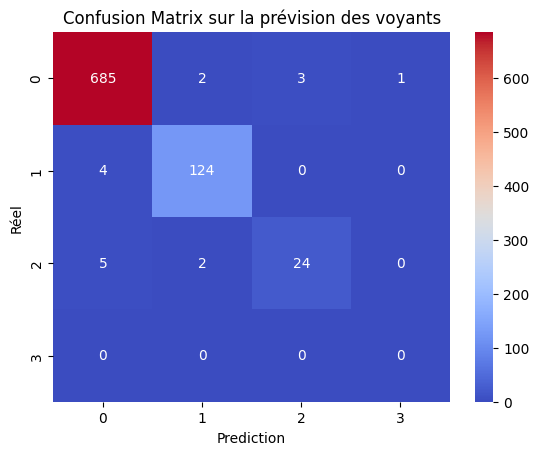

In [564]:
conf_matrix_rl = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix_rl, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Réel')

plt.title('Confusion Matrix sur la prévision des voyants')
plt.show()

# 5- Enregistrement model fullcompo avec le timeseries

In [565]:

# Enregistrer le modèle dans un fichier
joblib.dump(best_model_xgbc, 'best_model_avion_full_compo_timeSeries.pkl')

['best_model_avion_full_compo_timeSeries.pkl']

In [566]:
# colonne à mettre en entrée du model
len(X.columns)

97

# 6- Enregistrement dans la bdd des prediction sur la table logs_vols

In [567]:
# prediction sur l'ensemble des données
y_pred = pipeline_reg_log.predict(X)

In [568]:
# prendre les colonnes pour referencement sur df
df_pred = df[['aero_', 'measure_day_']].reset_index().drop('index', axis=1)

In [569]:
df_y_pred = pd.DataFrame(y_pred, columns=['Prediction']).reset_index().drop('index', axis=1)

In [570]:
# ajouter les predictions
df_pred = pd.concat([df_pred, df_y_pred], axis=1)

In [571]:
df_pred

aero_ measure_day_  Prediction
0     A320_1884   2024-06-20           0
1     A320_1884   2024-06-23           0
2     A320_1884   2024-06-24           0
3     A320_1884   2024-06-25           0
4     A320_1884   2024-06-26           0
...         ...          ...         ...
5509  E175_6879   2024-07-21           0
5510  E175_6879   2024-07-22           0
5511  E175_6879   2024-07-23           0
5512  E175_6879   2024-07-25           0
5513  E175_6879   2024-07-26           0

[5514 rows x 3 columns]

In [610]:
username = 'postgres'
password = 'admin'
host = '127.0.0.1'  # ou l'adresse IP de votre serveur PostgreSQL
port = '5432'  # le port par défaut pour PostgreSQL est 5432
database = 'preventive_maintenance'

# Créer l'URL de connexion
db_url = f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}'

# Créer le moteur SQLAlchemy
engine = create_engine(db_url)

# Créer un objet MetaData
metadata = MetaData()

# Définir la table en question
logs_vols = Table('logs_vols', metadata, autoload_with=engine)


In [612]:
# Se connecter à la base de données
with engine.connect() as connexion:
    
    # Démarrer une transaction
    transaction = connexion.begin()

    try:
        for i in range(len(df_pred)):

            prediction = int(df_pred.loc[i, 'Prediction'])
            aero_linked = df_pred.loc[i, 'aero_']
            jour_vol = df_pred.loc[i, 'measure_day_']

            # print(f"Attempting to update with: prediction={prediction}, aero_linked={aero_linked}, jour_vol={jour_vol}")


            # Créer l'objet UPDATE
            stmt = update(logs_vols).where(
                (logs_vols.c.aero_linked == aero_linked) &
                (logs_vols.c.jour_vol == jour_vol)
            ).values(prediction_etat_voyant=prediction)

            # print(str(stmt))

            # Exécuter la commande SQL avec les paramètres
            result = connexion.execute(stmt)
            # print(f"Rows affected: {result.rowcount}")


            # Vérifier si les données ont été mises à jour
            check_stmt = select(logs_vols).where(
                (logs_vols.c.aero_linked == aero_linked) &
                (logs_vols.c.jour_vol == jour_vol)
            )
            updated_rows = connexion.execute(check_stmt).fetchall()
            # print(f"Updated rows: {updated_rows}")
            # print()

        transaction.commit()
            
    except SQLAlchemyError as e:

        # Annuler (rollback) en cas d'erreur
        transaction.rollback()

        print(f"Une erreur est survenue : {e}")

Attempting to update with: prediction=0, aero_linked=A320_1884, jour_vol=2024-06-20 00:00:00
UPDATE logs_vols SET prediction_etat_voyant=:prediction_etat_voyant WHERE logs_vols.aero_linked = :aero_linked_1 AND logs_vols.jour_vol = :jour_vol_1
Rows affected: 1
Updated rows: [('V04360977', 'A320_1884', datetime.date(2024, 6, 20), 10.1, "{'temp': '8.0°C', 'pressure': '1090.2 hPa', 'vibrations': '1.7206686815860417 m/s²'}", 0, 8.0, '°C', 1090.2, ' hPa', 1.7206686815860417, ' m/s²', 0)]

Attempting to update with: prediction=0, aero_linked=A320_1884, jour_vol=2024-06-23 00:00:00
UPDATE logs_vols SET prediction_etat_voyant=:prediction_etat_voyant WHERE logs_vols.aero_linked = :aero_linked_1 AND logs_vols.jour_vol = :jour_vol_1
Rows affected: 1
Updated rows: [('V03578755', 'A320_1884', datetime.date(2024, 6, 23), 7.8, "{'temp': '6.3°C', 'pressure': '972.6 hPa', 'vibrations': '0.16085126119662174 m/s²'}", 0, 6.3, '°C', 972.6, ' hPa', 0.16085126119662174, ' m/s²', 0)]

Attempting to update with

In [613]:
connexion.close()